# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/18Kr-TZHaw9VL9PG52KsYXHc1N3fA3jAe?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:05<00:00, 28717934.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

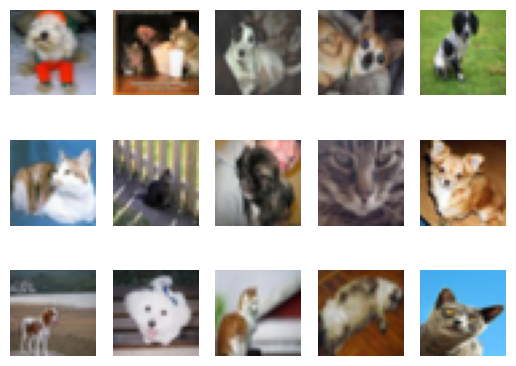

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

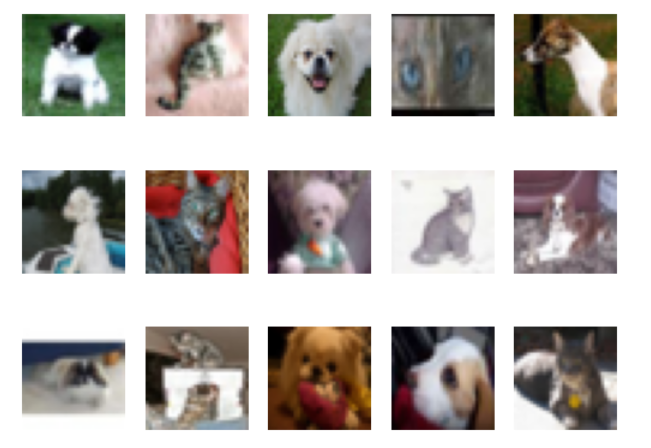

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
#Determining how many test values we have
print(len(test_loader))

#Determining how many training values we have
print(len(train_loader))

#Determining how man validation values we have
print(len(val_loader))

#We have 2000 testing, 2000 validation and 8000 training images

2000
8000
2000


**We have 2000 Testings, 2000 Validation and 8000 Training images**

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Validation is a procssess that allows us to ensure that the training processes itself is correct. Furthermore, training models can have low or minimal error but be underfitting/overfitting. Hence, Validation allows us to determine if any adjustments are needed for the training model. Hence we reserve a set of validation data that the model has not encountered before.**

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
count_small = 1
for param in small_net.parameters():
  for i in range(len(param.shape)):
    count_small = count_small*param.shape[i]
print(count_small)

count_large = 1
for param in large_net.parameters():
  for i in range(len(param.shape)):
    count_large = count_large*param.shape[i]
print(count_large)




165375
192000000000000


**There are 165375 parameters in the small net and 192000000000000 in large net**

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The defalt values are

**batch_size = 64
learning _rate = 0.01
num_epochs = 30**

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, 64, 0.01, 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.441, Train loss: 0.6788928790092468 |Validation err: 0.3835, Validation loss: 0.6601731739938259
Epoch 2: Train err: 0.3755, Train loss: 0.6508130488395691 |Validation err: 0.3815, Validation loss: 0.6570105478167534
Epoch 3: Train err: 0.3625, Train loss: 0.6413808460235596 |Validation err: 0.36, Validation loss: 0.6314445231109858
Epoch 4: Train err: 0.355875, Train loss: 0.6311400957107544 |Validation err: 0.3495, Validation loss: 0.6272203084081411
Epoch 5: Train err: 0.349125, Train loss: 0.6261632933616638 |Validation err: 0.3465, Validation loss: 0.6276663802564144
Finished Training
Total time elapsed: 25.14 seconds


**By viewing the files tabof the colab the following files were written to the disk:
1. model_small_bs64_lr0.01_epoch0
2. model_small_bs64_lr0.01_epoch1
3. model_small_bs64_lr0.01_epoch2
4. model_small_bs64_lr0.01_epoch3
5. model_small_bs64_lr0.01_epoch4
6. model_small_bs64_lr0.01_epoch4_train_err.csv
7. model_small_bs64_lr0.01_epoch4_train_loss.csv
8. model_small_bs64_lr0.01_epoch4_val_err.csv
9. model_small_bs64_lr0.01_epoch4_val_loss.csv

files 1 to 5 contain the saved values of the model paramters after each epoch runs

file 6 is the training error that is saved after each epoch is running
file 7 is the training loss values saved after each epoch is ran
file 8 is the validation error values saved after each epoch is ran
file 9 is the validation values lost after each epoch is run **




### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

#training with small_net
train_net(small_net, 64, 0.01, 30)
#time taken: 152.93 seconds

#training with large_net
train_net(large_net, 64, 0.01, 30)
#time taken: 168.57 seconds


Mounted at /content/gdrive
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4115, Train loss: 0.6705091967582703 |Validation err: 0.3865, Validation loss: 0.6607216075062752
Epoch 2: Train err: 0.377, Train loss: 0.6510712661743164 |Validation err: 0.395, Validation loss: 0.6644918285310268
Epoch 3: Train err: 0.350875, Train loss: 0.6311470670700073 |Validation err: 0.35, Validation loss: 0.6246338933706284
Epoch 4: Train err: 0.332375, Train loss: 0.6136552810668945 |Validation err: 0.351, Validation loss: 0.6260081585496664
Epoch 5: Train err: 0.32675, Train loss: 0.6054731097221374 |Validation err: 0.3375, Validation loss: 0.6190445311367512
Epoch 6: Train err: 0.318875, Train loss: 0.5959814190864563 |Validation err: 0.3315, Validation loss: 0.6165782455354929
Epoch 7: Train err: 0.32, Train loss: 0.5912996203899383 |Validation err: 0.338, Validation loss: 0.6097671641036868
Epoch 8: Train err: 0.31125, Train loss: 0.586204438209533

**The small_net took 152.93 seconds the large_net took 168.57 seconds. The large_net took longer since it had more parameters**

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

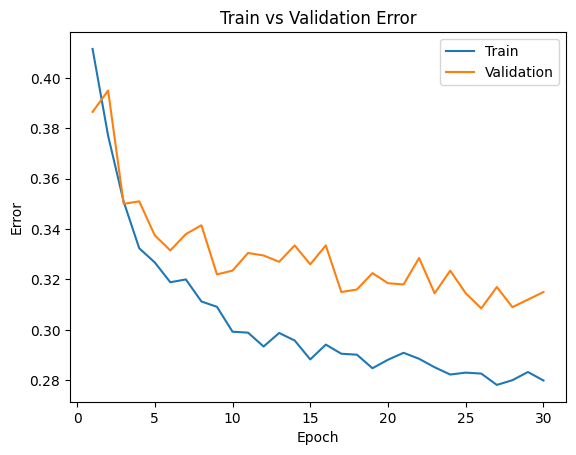

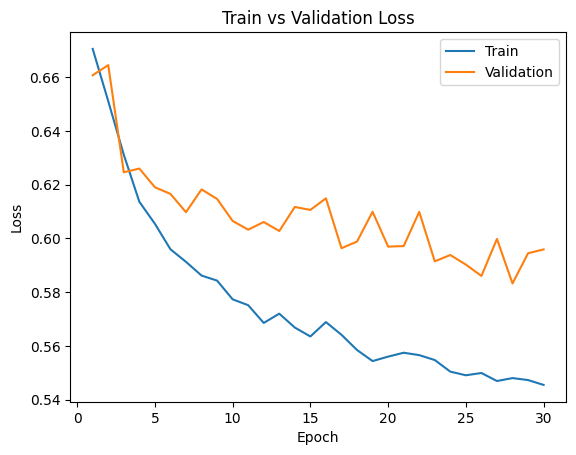

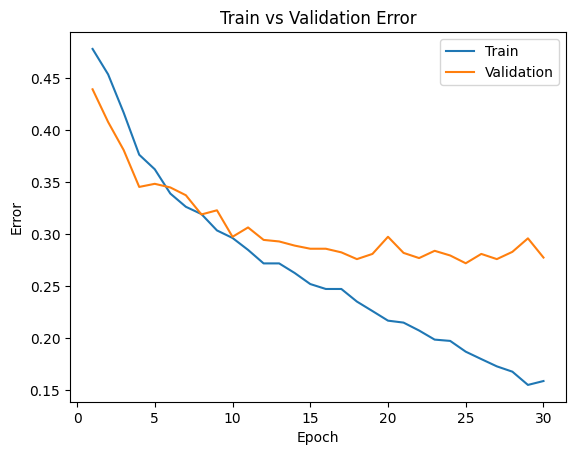

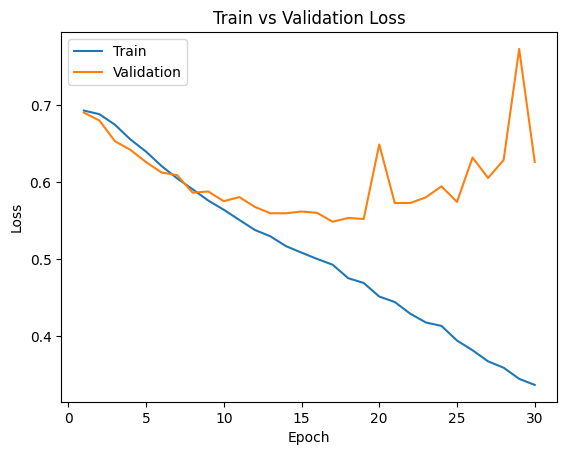

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

#Plotting small_net
model_path = get_model_name("small", batch_size = 64, learning_rate = 0.01, epoch = 29)
plot_training_curve(model_path)

#plotting Large_net
model_path = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)
plot_training_curve(model_path)

**Graph of Small Network Training vs. Validation Error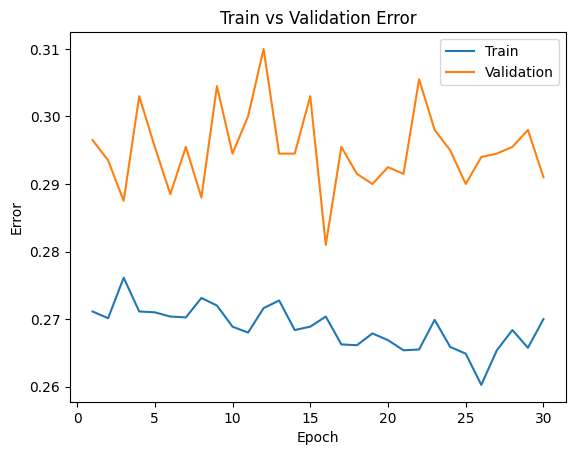**

**Graph of Small Network Training vs. Validation Loss**
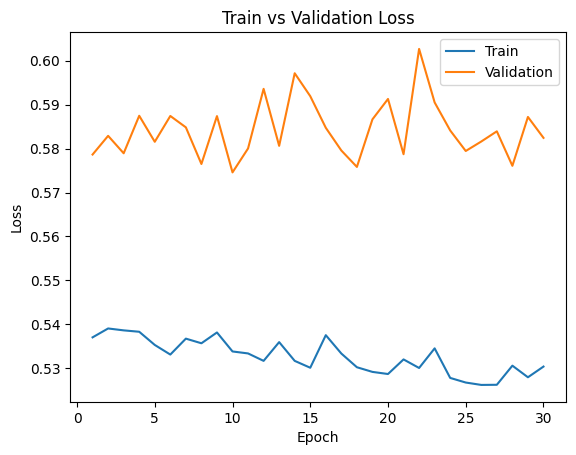
**Large Network Trainings vs. Validation Error**
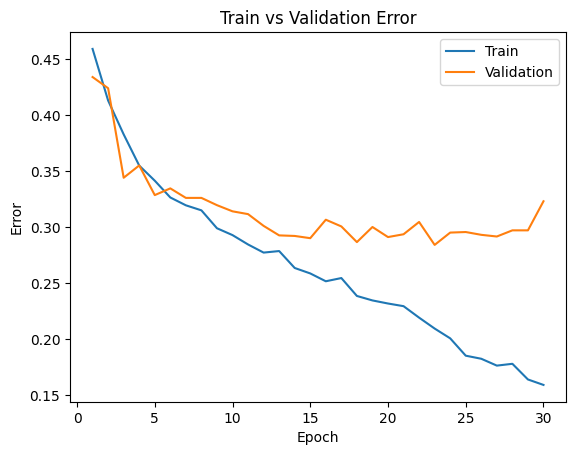

**Large Network Trainings vs. Validation Error**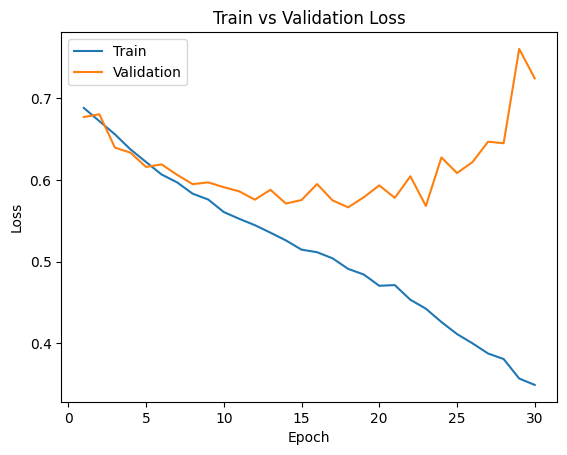


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**In the large and small networks the training curves decrease for both loss and error. This is more noticeable in the large network. However after a few epochs have passed, the decrease in the loss and error curves reduces and becomes more stagnant. This occures at around 10 epochs in the Large network and at around 2-3 ish epochs in the small network. In the Large network the loss and error curves begin to rise after this point indicating that the model is overfitting. Since the model is trained only with the training set data, it has adapted to predicting for the training data and not any foreign data. Hence this is a case of overfitting.**

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

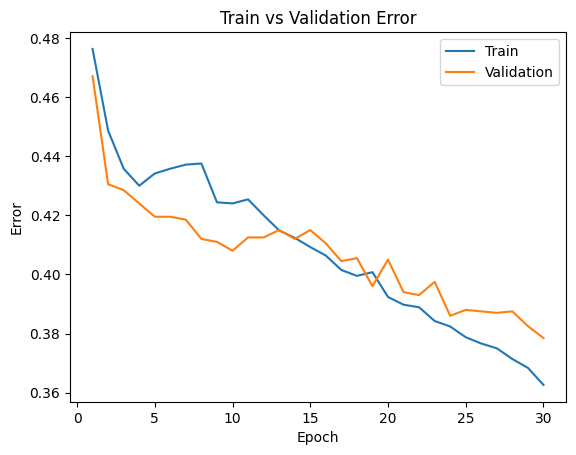

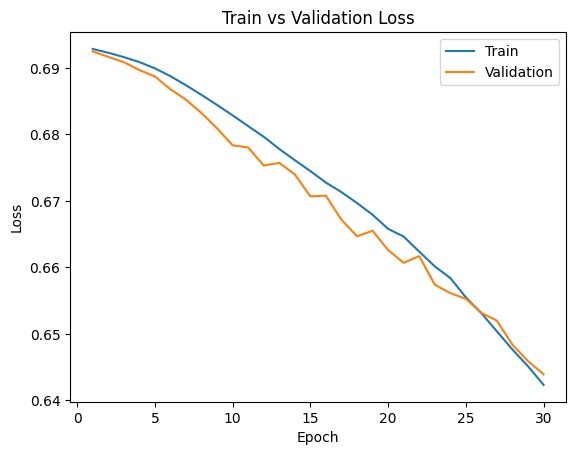

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
large_model_path = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_model_path)

**By lowering the learning rate, the loss and error curve also decreases with the training for more epochs. In this case at around 20 epochs the loss and error curves steadily decrease. This occured as parameters took smaller steps during each training round, allowing for the model to take its time and not converge too quickly. It did take a bit longer at around 175.28 seconds than with the larger learning rate. However the results obtained are much more satisfacotry outweighing the time taken.**

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

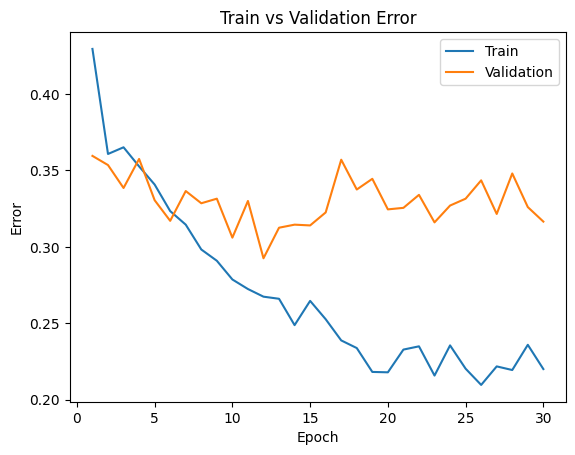

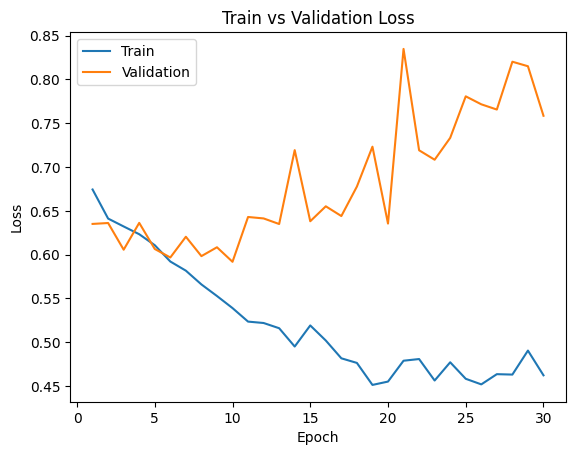

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
large_model_path = get_model_name("large", batch_size = 64, learning_rate = 0.1, epoch = 29)
plot_training_curve(large_model_path)

**This took 172.20 seconds to run a bit faster than when we had a reduced learning rate. However by increasing the learning rate we tend to have overfitting occur much earlier at about 5 epochs. Hence it is best to reduce the learning abeilt it may take a wee bit more time to produce results that are not severly overfitted.**

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

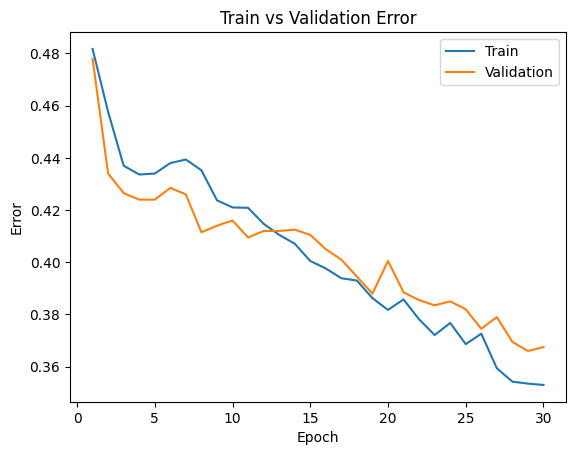

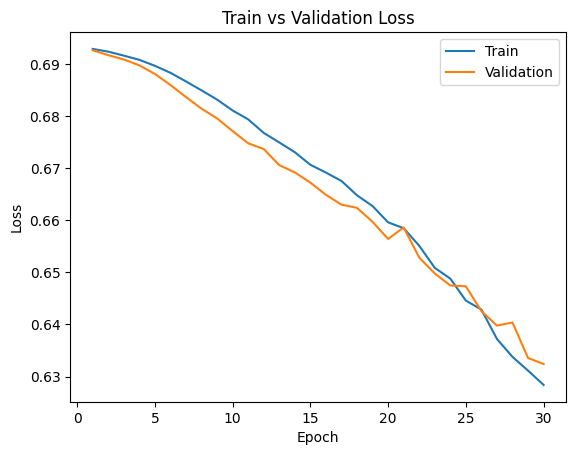

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 512)
large_model_path = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_model_path)

**The time taken with an increased batch size is 158.24 seconds, which is considerably shorter than the increased and decreased learning rate times. The speed could be justified by how the model looks at more data at time. This provided loss and error data that could be underfitted, as the validation curves align closesly with that of the training curves and dip below it as well. Since more images are taken at a time the model is generating results for a more gernalized dataset then a specific one causing underfitting.**



### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42425, Train loss: 0.6731642707586288 |Validation err: 0.352, Validation loss: 0.6391722741127014
Epoch 2: Train err: 0.362375, Train loss: 0.6372070057392121 |Validation err: 0.3545, Validation loss: 0.6231681959629058
Epoch 3: Train err: 0.34025, Train loss: 0.6072259551286697 |Validation err: 0.333, Validation loss: 0.6022160046100616
Epoch 4: Train err: 0.321875, Train loss: 0.5891620037555695 |Validation err: 0.319, Validation loss: 0.593191677570343
Epoch 5: Train err: 0.300875, Train loss: 0.5694989285469055 |Validation err: 0.304, Validation loss: 0.5807292046546936
Epoch 6: Train err: 0.29125, Train loss: 0.5500743905305863 |Validation err: 0.3135, Validation loss: 0.5843009662628174
Epoch 7: Train err: 0.278, Train loss: 0.5346856750547886 |Validation err: 0.299, Validation loss: 0.5690101804733276
Epoch 8: Train err: 0.2705, Train loss: 0.5211003004312516 |Validation err: 0.2985

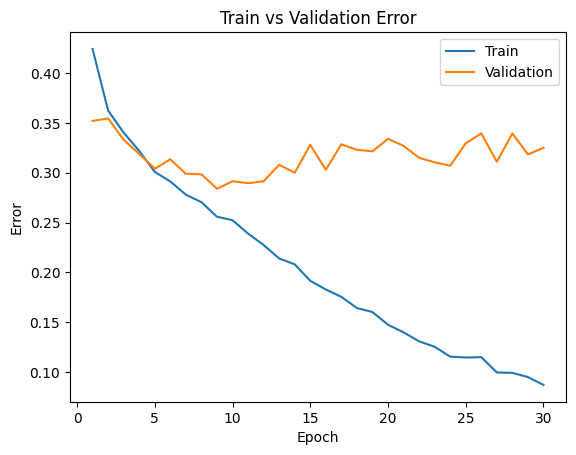

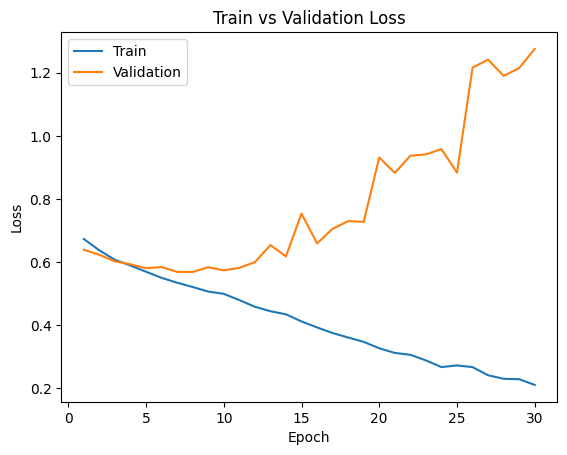

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 16)
large_model_path = get_model_name("large", batch_size = 16, learning_rate = 0.01, epoch = 29)
plot_training_curve(large_model_path)

**This took much longer at about 241.77 seconds. A smaller batch number indicates that the model needs to update the weights each time it runs and due to the reduced batch size it runs more often. The data however is now overfitted since the model evaluated each of the data inputs in small groups it has become good at working with only the training data.**

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**From the hyperparameters altered above the one that gave the best results was the increased batch size of 512 and when the learning rate was reduced to 0.001. The larger batch sized although led to underfitting, did lead training curve to align the loss and error curve more with itself. The reduced learning rate also reduced error. Choosing perhaps a batch size inbetween 512 and 64 such as 270 may yeild better results with a reduced learning rate of 0.001**

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.0001, batch_size = 200)
large_model_path = get_model_name("large", batch_size = 270, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

**The results produced are underfitted, perhaps increasing the amount of epochs, increasing the learning rate and reducing the batch size may lead to ideal results as observed from the behvaiours throughout the lab.**

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.514125, Train loss: 0.693522526572148 |Validation err: 0.51, Validation loss: 0.693097397685051
Epoch 2: Train err: 0.5115, Train loss: 0.6933053334554037 |Validation err: 0.5, Validation loss: 0.6929414719343185
Epoch 3: Train err: 0.49675, Train loss: 0.6930628642439842 |Validation err: 0.488, Validation loss: 0.692881832520167
Epoch 4: Train err: 0.485375, Train loss: 0.6928395256400108 |Validation err: 0.478, Validation loss: 0.6927320410807928
Epoch 5: Train err: 0.477375, Train loss: 0.6927202641963959 |Validation err: 0.4785, Validation loss: 0.692573348681132
Epoch 6: Train err: 0.471875, Train loss: 0.6925670665999254 |Validation err: 0.472, Validation loss: 0.692385862270991
Epoch 7: Train err: 0.468, Train loss: 0.6924357451498508 |Validation err: 0.4595, Validation loss: 0.6921856502691904
Epoch 8: Train err: 0.46575, Train loss: 0.6921782530844212 |Validation err: 0.4535, Vali

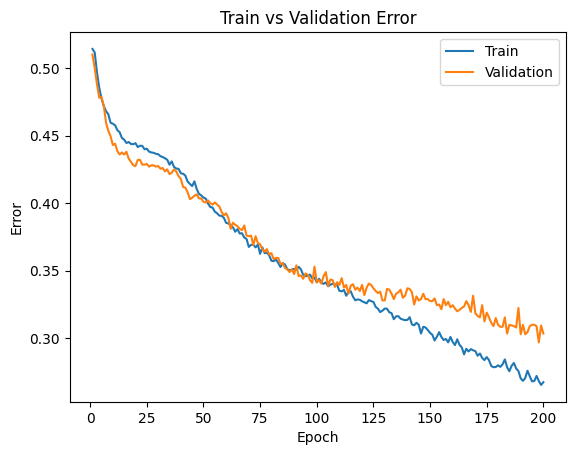

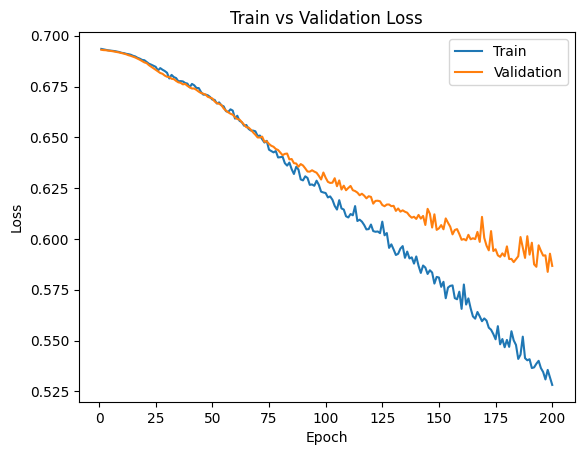

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 170, learning_rate = 0.001, num_epochs = 200)
large_model_path = get_model_name("large", batch_size = 170, learning_rate = 0.001, epoch = 199)
plot_training_curve(large_model_path)

**Train vs Validation Error**
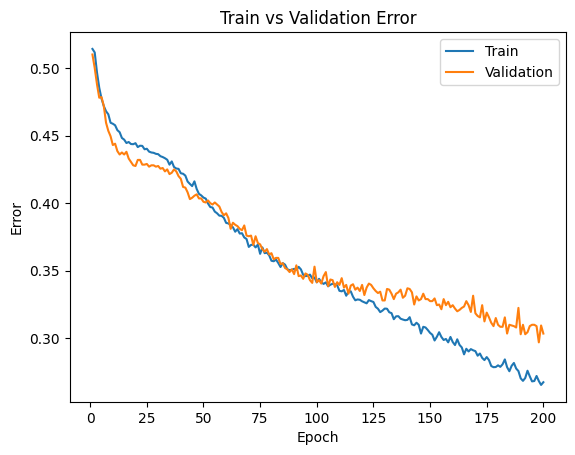

**Train vs. Validation Loss**
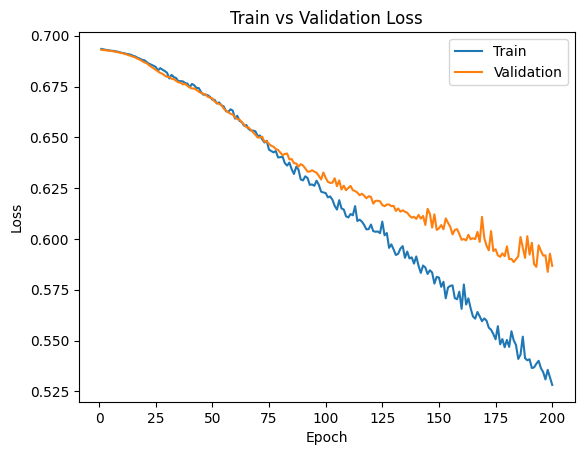

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name("large", batch_size= 170, learning_rate=0.005, epoch=150)
state = torch.load(large_model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Both nets performed well but the Large net performed the best interms of validation loss and error. Espiecally when passing through the changed hyperparameters, it produced more viable results**

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size= 170)

testing = nn.BCEWithLogitsLoss()

test_err, test_loss = evaluate(net, test_loader, testing)
print("Testing error:" ,test_err, "Testing loss:", test_loss)

val_err, val_loss = evaluate(net, val_loader, testing)
print("Validation error:", val_err, "Validation loss:", val_loss)

Files already downloaded and verified
Files already downloaded and verified
Testing error: 0.2945 Testing loss: 0.5808470199505488
Validation error: 0.3035 Validation loss: 0.5870283295710882


**Test classification error for the model is 0.2945**

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**The testing error is a little less than the validation error. This goes against the expectation, as typically the testing error would be higher since the model is adjusted to work better with the training data. Therefore the testing error should have been higher than the validation error since it was would introducing new data that the changes in the models hyperparameters did not acount for**

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**To ensure that the model is working as accurately as possible it is important that new and fresh data is fed into the model to see how it performs. Typically when we train the model we adjust parameters to ensure that the model is wokring well. Hence the model can sometimes end up being underfit or overfitted with the training data. We can identify this only if we use testing data near the end that shows us how we may have skewed our model. As such when we make adjustments again with the test data we want to do it as little as possible to avoid further over and under fitting**

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

****

In [ ]:
#The ANN from Lab 1:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 999)
        self.layer2 = nn.Linear(999, 30)
        self.layer3 = nn.Linear(30, 1)

    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)

        return activation3.squeeze(1)

pigeon = Pigeon()

train_loader, val_loader, test_loader, classes = get_data_loader( target_classes = ["cat", "dog"], batch_size = 170)

train_net(pigeon,batch_size = 170, learning_rate = 0.001, num_epochs = 150)

testing = nn.BCEWithLogitsLoss()

test_err, test_loss = evaluate(net, test_loader, testing)

print("Test error", test_err)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44625, Train loss: 0.6904437268773714 |Validation err: 0.445, Validation loss: 0.6886386026938757


AttributeError: ignored